In [4]:
# Importando Bibliotecas
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
import matplotlib.animation as animation
import pandas as pd
# plt.rcParams['animation.ffmpeg_path'] = 'C:/ffmpeg/bin/ffmpeg.exe'
plt.rcParams['animation.ffmpeg_path'] = 'E:/Arquivos de Programas/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'

In [5]:
# Classe para as Espiras
class Coil:
    def __init__(self, spring_constant, mass, initial_y, initial_v, is_first=False, is_last=False):
        self.spring_constant = spring_constant
        self.mass = mass
        self.is_first = is_first
        self.is_last = is_last

        self.velocity = initial_v
        self.position = initial_y

    def edo_position(self):
        return self.velocity

    def edo_velocity(self, g, prev_position, next_position):
        if not self.is_first and not self.is_last:
            value = -g + (-((self.spring_constant / self.mass) * abs(next_position - self.position)) \
                                + ((self.spring_constant / self.mass) * abs(self.position - prev_position)))
        elif self.is_first:
            value = -g - ((self.spring_constant / self.mass) * abs(next_position - self.position))
        else:
            value = -g + ((self.spring_constant / self.mass) * abs(self.position - prev_position))

        return round(value, 4)

    def __str__(self):
        return (f'Coil(spring_constant={self.spring_constant}, mass={self.mass}, initial_position={self.position}, '
                f'initial_velocity={self.velocity}, is_first={self.is_first}, is_last={self.is_last})')

In [6]:
# Classe da Mola
class Spring:
    def __init__(self, N, spring_constant, total_mass, rest_length, gravity=10):
        self.original_N = N
        self.N = N
        self.spring_constant = spring_constant
        self.total_mass = total_mass
        self.gravity = gravity
        self.rest_length = rest_length
        self.coils = []

    def reset(self):
        self.N = self.original_N
        self.coils = []
        for i in range(self.original_N):
            self.coils.append(
                Coil(
                    spring_constant=self.spring_constant * (self.original_N - 1),
                    mass=self.total_mass / self.original_N,
                    initial_y=0,
                    initial_v=0,
                    is_first=i == 0,
                    is_last=i == (self.original_N - 1)
                )
            )

        self.coils[0].position = 0
        prev_position = 0
        for idx, coil in enumerate(self.coils[1:]):
            correct_idx = idx + 1
            summation = (-self.gravity / coil.spring_constant) * sum([c.mass for c in self.coils[correct_idx:]])
            coil.position = prev_position + summation
            prev_position = coil.position

    def euler_step(self, step):
        new_positions = []
        new_velocities = []
        for idx, coil in enumerate(self.coils):
            prev_position = self.coils[idx - 1].position if idx > 0 else 0
            next_position = self.coils[idx + 1].position if idx < self.N - 1 else 0
            new_positions.append(coil.position + step * coil.edo_position())
            new_velocities.append(coil.velocity + step * coil.edo_velocity(self.gravity, prev_position, next_position))

        for idx, coil in enumerate(self.coils):
            coil.position = new_positions[idx]
            coil.velocity = new_velocities[idx]

        if len(self.coils) > 1 and self.coils[0].position <= self.coils[1].position:
            self.collision()

    def collision(self):
        coil1 = self.coils.pop(0)
        coil2 = self.coils.pop(0)

        combined_mass = coil1.mass + coil2.mass
        combined_velocity = (coil1.mass * coil1.velocity + coil2.mass * coil2.velocity) / combined_mass

        combined_coil = Coil(
            spring_constant=coil1.spring_constant,
            mass=combined_mass,
            initial_y=coil2.position,
            initial_v=combined_velocity,
            is_first=True,
            is_last=len(self.coils) == 1
        )

        self.coils.insert(0, combined_coil)
        self.N -= 1

    def plot_wave(self, start, end, frequency=1):
        amplitude = 0.1
        wavelength = end - start
        x = np.linspace(start, end, 1000)
        y = amplitude * np.sin(2 * np.pi * (x - start) * frequency / wavelength)
        return x, y

    def plot_spring(self, include_initial_size=True):
        i = 0
        x_arr = np.array([])
        y_arr = np.array([])
        if len(self.coils) > 1:
            for coil1, coil2 in zip(self.coils[:-1], self.coils[1:]):
                if i == 0 and include_initial_size:
                    x, y = self.plot_wave(coil1.position + self.rest_length, coil1.position,
                                          ((self.original_N + 1) - self.N))
                    x_arr = np.concatenate((x_arr, x))
                    y_arr = np.concatenate((y_arr, y))

                x, y = self.plot_wave(coil1.position, coil2.position, 1)
                x_arr = np.concatenate((x_arr, x))
                y_arr = np.concatenate((y_arr, y))
                i += 1
        else:
            x, y = self.plot_wave(self.coils[0].position - self.rest_length, self.coils[0].position,
                                  self.original_N)
            x_arr = np.concatenate((x_arr, x))
            y_arr = np.concatenate((y_arr, y))

        return x_arr, y_arr

    def __str__(self):
        coils_str = '\n'.join([str(coil) for coil in self.coils])
        return f'Spring(N={self.N}, spring_constant={self.spring_constant}, total_mass={self.total_mass})\nCoils:\n{coils_str}'


In [7]:
def animate_spring(
        model,
        animation_name,
        step=0.001,
        video_speed=1,
        include_initial_size=True,
        xlim=(-0.01, 0.25),
        ylim=(-2, 0.2),
):
    model.reset()

    fig = plt.figure()
    axis = plt.axes(
        xlim=xlim,
        ylim=ylim
    )

    line, = axis.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        model.euler_step(step=step)
        x, y = model.plot_spring(include_initial_size=include_initial_size)
        line.set_data(y, x)

        return line,

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=int(1 // step),
        interval=0,
        blit=True
    )

    anim.save(f'{animation_name}.mp4', writer='ffmpeg', fps=(1 / step) * video_speed)

def coil_positions(
        model,
        step=0.001,
        max_time=0.45,
        num_coils=10,
):
    model.reset()

    coil_positions = []
    for i in range(int(1 // step)):
        positions = np.array([model.coils[0].position for _ in range(num_coils - len(model.coils))] +
                             [coil.position for coil in model.coils])
        coil_positions.append(positions)
        model.euler_step(step=step)

    position_coil0 = [positions[0] for positions in coil_positions[:int(max_time // step)]]
    position_coil2 = [positions[2] for positions in coil_positions[:int(max_time // step)]]
    position_coil5 = [positions[4] for positions in coil_positions[:int(max_time // step)]]
    position_coil6 = [positions[6] for positions in coil_positions[:int(max_time // step)]]
    position_coil9 = [positions[9] for positions in coil_positions[:int(max_time // step)]]

    y_axis = np.arange(0, int(max_time // step), int(max_time // step) / len(position_coil0)) * step

    coil_positions = np.array(coil_positions)
    plt.plot(y_axis, position_coil0)
    plt.plot(y_axis, position_coil2)
    plt.plot(y_axis, position_coil5)
    plt.plot(y_axis, position_coil6)
    plt.plot(y_axis, position_coil9)
    
    return coil_positions

dict_items([('metal_small', <__main__.Spring object at 0x000001E295C1E6B0>), ('metal_big', <__main__.Spring object at 0x000001E295C1E740>), ('plastic', <__main__.Spring object at 0x000001E295C1E830>)])


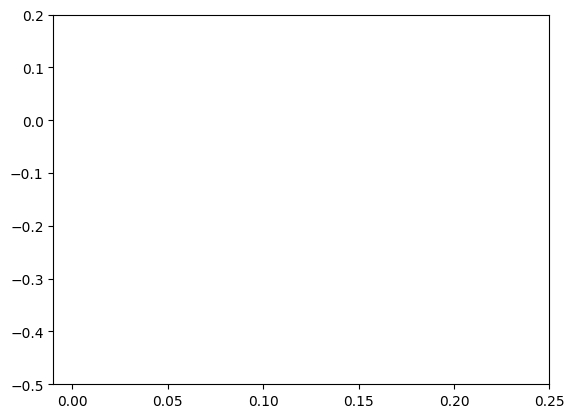

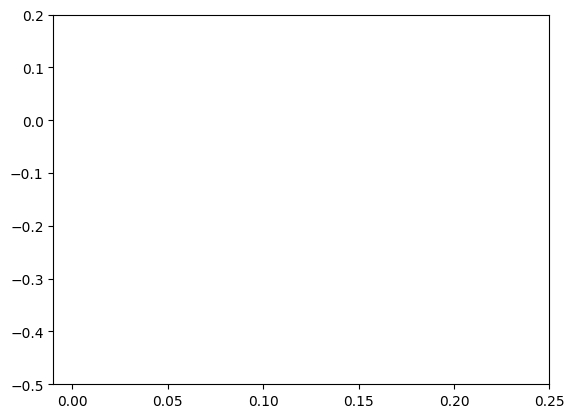

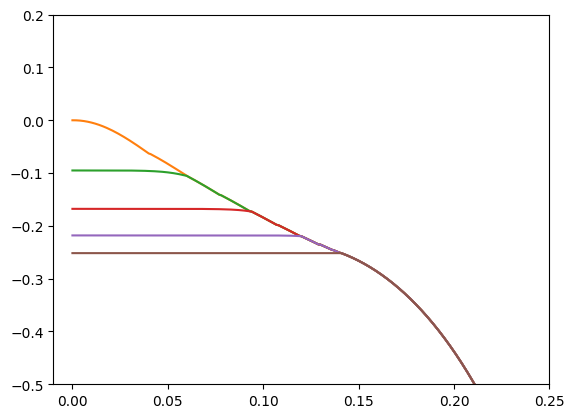

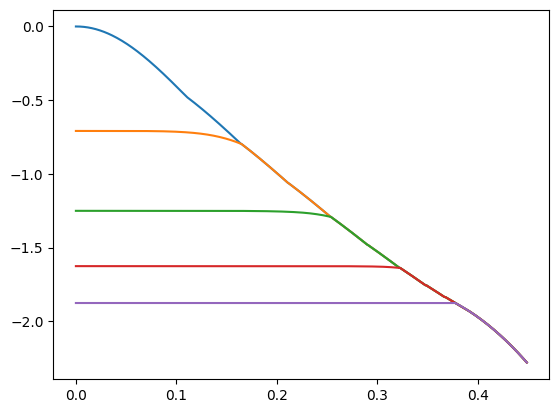

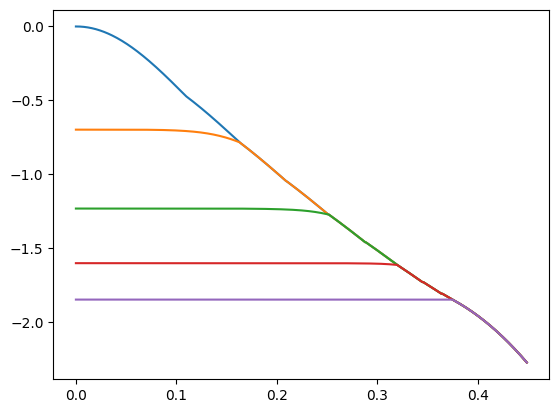

(0.14100000000000001, 0.378, 0.375)

In [8]:
models = {
    'metal_small': Spring(N=10, spring_constant=1.889, total_mass=0.097, rest_length=0.028, gravity=9.8),
    'metal_big': Spring(N=10, spring_constant=0.6556369155, total_mass=0.2510, rest_length=0.0722, gravity=9.8),
    'plastic': Spring(N=10, spring_constant=0.1160296315, total_mass=0.0437, rest_length=0.0722, gravity=9.8),
}
print(models.items())
for name, model in models.items():
    if name == 'metal_small':
        animate_spring(model=model, animation_name=name, video_speed=1/3, xlim=(-0.01, 0.25),  ylim=(-0.5, 0.2))
    else:
        animate_spring(model=model, animation_name=name, video_speed=1/3, ylim=(-0.5, 0.2))

df = []

for name, model in models.items():
    df.append(coil_positions(model))
    plt.savefig(f'{name}.png')
    plt.show()

analysis_df = pd.DataFrame(df[0])
small_metal_fall_time = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

analysis_df = pd.DataFrame(df[1])
big_metal_fall_time = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

analysis_df = pd.DataFrame(df[2])
plastic_fall_time = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

small_metal_fall_time, big_metal_fall_time, plastic_fall_time

[0,
 -0.3828338430403711,
 -0.7231305924095899,
 -1.0208902481076563,
 -1.2761128101345705,
 -1.4887982784903322,
 -1.6589466531749415,
 -1.7865579341883986,
 -1.8716321215307032,
 -1.9141692152018557]

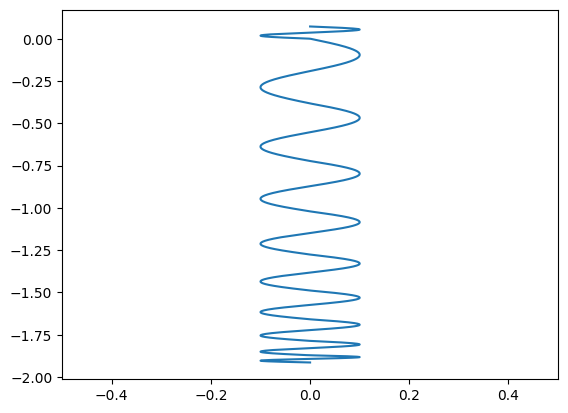

In [9]:
test = Spring(N=10, spring_constant=0.6556369155, total_mass=0.2510, rest_length=0.0722, gravity=10)
test.reset()
x, y = test.plot_spring()
plt.plot(y, x)
plt.xlim([-0.5, 0.5])
test_1 = [coil.position for coil in test.coils]
test_1

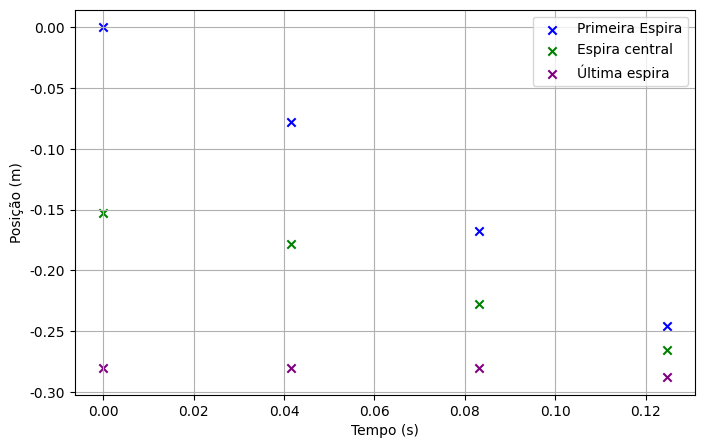

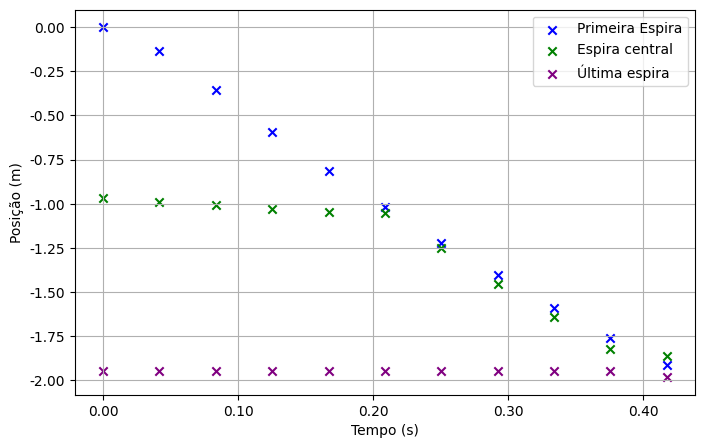

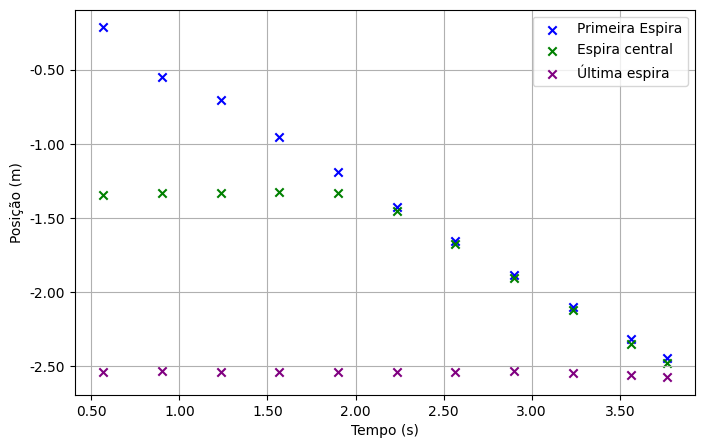

In [10]:
df = pd.read_csv("data/experimental_data.csv")

# Lista de molas presentes no DataFrame
springs = df['Mola'].unique()

# Criar gráfico para cada mola
for spring in springs:
    df_spring = df[df['Mola'] == spring]

    plt.figure(figsize=(8, 5), facecolor='white')
    plt.xlabel("Tempo (s)")
    plt.ylabel("Posição (m)")
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # Adiciona linhas para cada espira
    plt.scatter(
        df_spring['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_spring['Posição (metro) Espira 1'].str.replace(',', '.').astype(float),
        marker='x',
        label='Primeira Espira',
        color='blue'
    )

    plt.scatter(
        df_spring['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_spring['Posição (metro) Espira meio'].str.replace(',', '.').astype(float),
        marker='x',
        label='Espira central',
        color='green'
    )

    plt.scatter(
        df_spring['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_spring['Posição (metro) Espira ultima'].str.replace(',', '.').astype(float),
        marker='x',
        label='Última espira',
        color='purple'
    )

    # if spring == 1:
    #     coil_positions(models['metal'])
    #
    # if spring == 2:
    #     coil_positions(models['plastic'])

    plt.legend()
    plt.grid(True)
    plt.savefig(f'{spring}')
    plt.show()